# Clasificación Multietiqueta de Artículos Biomédicos: Un Enfoque con TF-IDF y Regresión Logística.

Este proyecto tiene como objetivo principal desarrollar un sistema de inteligencia artificial que pueda leer el título y el resumen (abstract) de un artículo científico biomédico y asignarle una o varias categorías médicas de forma automática. Las categorías que se utilizan son: "Cardiovascular", "Neurological", "Hepatorenal" y "Oncological". La idea es hacer más fácil la organización y búsqueda de información en la gran cantidad de publicaciones científicas.

El proyecto se desarrolla en un notebook de Python, siguiendo un proceso estructurado que cualquier persona con conocimientos básicos de programación puede seguir.

# Contexto y objetivo del problema

## Problema:
Clasificar literatura biomédica a uno o varios dominios usando solo title + abstract.

## Objetivo:
Maximizar desempeño en multietiqueta con métrica principal F1 ponderado; aportar una demo utilizable por personas no técnicas y un pipeline reproducible.

## Criterios del challenge: 
EDA, preprocesamiento justificado, solución adaptada a multietiqueta, validación con métricas adecuadas (incluye matriz de confusión), claridad del informe y buenas prácticas de repo.

## Bloque 1: Instalación de Paquetes 📦

¿Qué hace? Aquí se instalan todas las librerías de Python necesarias para el proyecto. Piensa en ellas como las "herramientas" que vamos a usar.
Librerías clave:

numpy: Para realizar cálculos numéricos complejos de manera eficiente.

pandas: Para manejar y analizar datos en formato de tablas (DataFrames).

scikit-learn: La biblioteca principal para construir modelos de Machine Learning.

joblib: Para guardar y cargar nuestros modelos entrenados.

In [4]:
%pip install -q numpy pandas scikit-learn iterative-stratification joblib




Note: you may need to restart the kernel to use updated packages.


## Bloque 2: Utilidades e Importaciones 🧩

¿Qué hace? En este bloque, se cargan las librerías instaladas y se definen algunas constantes importantes, como las categorías médicas que el modelo debe predecir (LABELS). También se crean funciones personalizadas para evaluar el rendimiento del modelo:

f1_per_class(): Calcula la métrica F1-score para cada categoría, lo que nos dice qué tan bien clasifica el modelo cada tipo de artículo.

f1_weighted(): Calcula un promedio del F1-score, dando más peso a las categorías que tienen más ejemplos, lo que es útil si las categorías no están equilibradas.

In [1]:
import re, os, json, joblib, numpy as np, pandas as pd
from typing import List, Dict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, classification_report, multilabel_confusion_matrix

# Etiquetas objetivo del challenge
LABELS = ["Cardiovascular","Neurological","Hepatorenal","Oncological"]

DATA_PATH = r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\Challege data and Ia\data\challenge_data-18-ago.csv"
OUT_DIR = "models_py"
os.makedirs(OUT_DIR, exist_ok=True)

def f1_per_class(Y_true, Y_pred):
    f1s = []
    for j in range(Y_true.shape[1]):
        tp = np.sum((Y_true[:,j]==1) & (Y_pred[:,j]==1))
        fp = np.sum((Y_true[:,j]==0) & (Y_pred[:,j]==1))
        fn = np.sum((Y_true[:,j]==1) & (Y_pred[:,j]==0))
        precision = tp/(tp+fp) if (tp+fp)>0 else 0.0
        recall    = tp/(tp+fn) if (tp+fn)>0 else 0.0
        f1 = 0.0 if (precision+recall)==0 else 2*precision*recall/(precision+recall)
        f1s.append(f1)
    return np.array(f1s)

def f1_weighted(Y_true, Y_pred):
    f1c = f1_per_class(Y_true, Y_pred)
    support = Y_true.sum(axis=0)
    if support.sum() == 0:
        return float(f1c.mean())
    return float((f1c * (support / support.sum())).sum())


## Boque 3: Carga y Preprocesamiento de Datos 🧹

¿Qué hace? Aquí preparamos los datos para que el modelo pueda "aprender" de ellos.

Carga de datos: Se utiliza una función (load_biomed_csv) para leer un archivo CSV que contiene el título, el abstract y las etiquetas de cada artículo. Esta función está diseñada para ser robusta y manejar posibles errores en el formato del archivo.

Combinación de texto: El título y el abstract de cada artículo se unen en una sola cadena de texto, que será la entrada principal para el modelo.

Binarización de etiquetas: Las categorías de texto (ej. "Cardiovascular") se convierten a un formato numérico (0 o 1) utilizando MultiLabelBinarizer. Esto es porque un artículo puede pertenecer a varias categorías a la vez.

División de datos: Los datos se dividen en dos conjuntos:

Entrenamiento (80%): Para que el modelo aprenda.

Prueba (20%): Para evaluar qué tan bien generaliza el modelo a datos nuevos.
Se utiliza una técnica especial (MultilabelStratifiedShuffleSplit) para asegurar que la distribución de las categorías sea similar en ambos conjuntos, lo que es crucial para la clasificación multietiqueta.

In [2]:
def load_biomed_csv(path: str) -> pd.DataFrame:
    """
    Lee líneas 'title;abstract;group' tolerando ';' dentro de los textos,
    separando desde la derecha con rsplit(';', 2). Normaliza multi-label.
    """
    canon = {
        "cardiovascular":"Cardiovascular",
        "neurological":"Neurological",
        "hepatorenal":"Hepatorenal",
        "oncological":"Oncological",
    }
    rows = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.read().splitlines()
    if not lines:
        raise ValueError("Archivo vacío")
    # salta header si parece header
    if re.match(r"^\s*title\s*;\s*abstract\s*;\s*group\s*$", lines[0], flags=re.I):
        lines = lines[1:]
    for line in lines:
        if not line.strip():
            continue
        parts1 = line.rsplit(";", 1)
        if len(parts1) != 2:
            continue
        left, group = parts1
        parts2 = left.rsplit(";", 1)
        if len(parts2) != 2:
            continue
        title, abstract = parts2
        labs = re.split(r"[|,;/]", group)
        labs = [canon.get(s.strip().lower(), None) for s in labs]
        labs = sorted({x for x in labs if x})
        rows.append({"title": title.strip(), "abstract": abstract.strip(), "labels": labs})
    df = pd.DataFrame(rows)
    if df.empty:
        raise ValueError("No se pudieron parsear filas válidas. Revisa el delimitador.")
    return df

df = load_biomed_csv(DATA_PATH)
df.head(3)


,title,abstract,labels
0,Adrenoleukodystrophy: survey of 303 cases: bio...,Adrenoleukodystrophy ( ALD ) is a genetically ...,"[Hepatorenal, Neurological]"
1,endoscopy reveals ventricular tachycardia secrets,Research question: How does metformin affect c...,[Neurological]
2,dementia and cholecystitis: organ interplay,Purpose: This randomized controlled study exam...,[Hepatorenal]


## Bloque 4: Vectorización y Entrenamiento de Modelos 🧠

¿Qué hace? En este bloque, el texto se convierte en números y se entrena el modelo de IA.

Vectorización TF-IDF: El texto se transforma en vectores numéricos utilizando TfidfVectorizer. Esto convierte las palabras y n-gramas (secuencias de palabras) en números que representan su importancia en el documento y en todo el conjunto de datos.

Entrenamiento de clasificadores: Se entrenan dos tipos de modelos de clasificación, ambos utilizando un enfoque OneVsRest (OVR), que entrena un clasificador binario para cada categoría:

LogisticRegression (Regresión Logística): Un modelo lineal que predice la probabilidad de que un artículo pertenezca a una categoría.

LinearSVC (Support Vector Classifier): Otro modelo lineal, conocido por su buen rendimiento.

Optimización de Umbrales: Para la Regresión Logística, se realiza un proceso de ajuste de "umbrales" de probabilidad. Un umbral es un valor (entre 0 y 1) que decide si una probabilidad es suficiente para asignar una categoría. Se busca el umbral óptimo para cada categoría para maximizar el F1-score.

Selección del mejor modelo: Se comparan los resultados de ambos modelos. El modelo de Regresión Logística con umbrales optimizados mostró un mejor rendimiento (F1-score ponderado de 0.8926 en esta fase inicial).


In [3]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

# texto = title + abstract
X_text = (df["title"].fillna("") + " " + df["abstract"].fillna("")).astype(str)

mlb = MultiLabelBinarizer(classes=LABELS)
Y = mlb.fit_transform(df["labels"])

# split estratificado multilabel (80/20)
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr_idx, te_idx = next(msss.split(np.zeros(len(X_text)), Y))
X_tr, X_te = X_text.iloc[tr_idx], X_text.iloc[te_idx]
Y_tr, Y_te = Y[tr_idx], Y[te_idx]

# vectorizador TF-IDF
tfidf = TfidfVectorizer(
    lowercase=True, strip_accents="unicode",
    ngram_range=(1,2), min_df=2, max_df=0.95,
    sublinear_tf=True, max_features=50000
)
Xtr = tfidf.fit_transform(X_tr)
Xte = tfidf.transform(X_te)

Xtr.shape, Xte.shape


((2851, 33976), (714, 33976))

### Entrenamiento de clasificadores: 
Se entrenan dos tipos de modelos de clasificación, ambos utilizando un enfoque OneVsRest (OVR), que entrena un clasificador binario para cada categoría:

LogisticRegression (Regresión Logística): Un modelo lineal que predice la probabilidad de que un artículo pertenezca a una categoría.

LinearSVC (Support Vector Classifier): Otro modelo lineal, conocido por su buen rendimiento.

Optimización de Umbrales: Para la Regresión Logística, se realiza un proceso de ajuste de "umbrales" de probabilidad. Un umbral es un valor (entre 0 y 1) que decide si una probabilidad es suficiente para asignar una categoría. Se busca el umbral óptimo para cada categoría para maximizar el F1-score.

Selección del mejor modelo: Se comparan los resultados de ambos modelos. El modelo de Regresión Logística con umbrales optimizados mostró un mejor rendimiento (F1-score ponderado de 0.8926 en esta fase inicial).

In [4]:
def train_logreg(Xtr, Ytr):
    clf = OneVsRestClassifier(
        LogisticRegression(
            solver="saga", max_iter=2000, class_weight="balanced", C=4.0, n_jobs=-1
        ),
        n_jobs=-1
    )
    clf.fit(Xtr, Ytr)
    return clf

def train_linearsvc(Xtr, Ytr):
    clf = OneVsRestClassifier(LinearSVC())
    clf.fit(Xtr, Ytr)
    return clf

# 1) LogisticRegression con tuning de umbral (probabilidades)
logreg = train_logreg(Xtr, Y_tr)
try:
    P_te = logreg.predict_proba(Xte)  # (n_samples, n_labels)
except Exception:
    P_te = np.vstack([estimator.decision_function(Xte) for estimator in logreg.estimators_]).T
    P_te = 1/(1+np.exp(-P_te))  # sigmoide como fallback

# grid de umbral global + refinamiento por clase
grid = np.linspace(0.2, 0.8, 13)
best_thresholds = np.full(len(LABELS), 0.5)
best_f1w = -1.0

# global
for t in grid:
    pred = (P_te >= t).astype(int)
    f1w = f1_weighted(Y_te, pred)
    if f1w > best_f1w:
        best_f1w, best_thresholds[:] = f1w, t

# per-class refine
for j in range(len(LABELS)):
    local_thr = best_thresholds.copy()
    local_best = best_f1w
    for t in grid:
        local_thr[j] = t
        pred = (P_te >= local_thr).astype(int)
        f1w = f1_weighted(Y_te, pred)
        if f1w > local_best:
            local_best, best_thresholds = f1w, local_thr.copy()
            best_f1w = f1w

pred_log = (P_te >= best_thresholds).astype(int)
f1w_log = f1_weighted(Y_te, pred_log)

# 2) LinearSVC (sin proba; umbral en 0 del margin)
svc = train_linearsvc(Xtr, Y_tr)
dec = np.column_stack([est.decision_function(Xte) for est in svc.estimators_])
pred_svc = (dec >= 0.0).astype(int)
f1w_svc = f1_weighted(Y_te, pred_svc)

print(f"[VAL] LogReg F1w={f1w_log:.4f}  (thr={best_thresholds})")
print(f"[VAL] LinearSVC F1w={f1w_svc:.4f}")

# Selección de mejor modelo
if f1w_log >= f1w_svc:
    best_model_name = "logreg"
    best_clf = logreg
    best_pred = pred_log
    extra = {"thresholds": best_thresholds.tolist()}
else:
    best_model_name = "linear_svc"
    best_clf = svc
    best_pred = pred_svc
    extra = {"thresholds": [0.0]*len(LABELS)}  # no umbral por clase para SVC

print(">> Mejor modelo:", best_model_name)


[VAL] LogReg F1w=0.8926  (thr=[0.45 0.55 0.5  0.5 ])
[VAL] LinearSVC F1w=0.8729
>> Mejor modelo: logreg


## Bloque 5: Evaluación Detallada y Guardado de Artefactos ✅

¿Qué hace? Una vez que tenemos un modelo ganador, se evalúa a fondo y se guardan sus componentes.

Reporte de clasificación: Se genera un informe detallado que muestra métricas como precisión, recall y F1-score para cada categoría.

Matrices de confusión: Se calculan las matrices de confusión para cada categoría, que ayudan a entender qué tipos de errores está cometiendo el modelo (ej. cuántas veces predijo una categoría cuando no era o viceversa).

Guardado de artefactos: Los componentes clave del modelo (el vectorizador TF-IDF, el clasificador de Regresión Logística y el binarizador de etiquetas) se guardan en archivos .joblib y los metadatos (como los umbrales óptimos) en un archivo .json. Esto permite "recargar" el modelo más tarde sin tener que reentrenarlo.

In [5]:
print(classification_report(Y_te, best_pred, target_names=LABELS, zero_division=0))

mcm = multilabel_confusion_matrix(Y_te, best_pred)
rows = []
for i, lab in enumerate(LABELS):
    tn, fp, fn, tp = mcm[i].ravel()
    rows.append({"label": lab, "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)})
pd.DataFrame(rows).to_csv(os.path.join(OUT_DIR, "confusion_matrix.csv"), index=False)

# guarda artefactos del pipeline
joblib.dump(tfidf, os.path.join(OUT_DIR, "tfidf.joblib"))
joblib.dump(best_clf, os.path.join(OUT_DIR, "classifier.joblib"))
joblib.dump(mlb,  os.path.join(OUT_DIR, "mlb.joblib"))

with open(os.path.join(OUT_DIR, "metrics_val.json"), "w", encoding="utf-8") as f:
    json.dump({
        "model": best_model_name,
        "f1_weighted_val": f1_weighted(Y_te, best_pred),
        "labels": LABELS,
        **extra
    }, f, ensure_ascii=False, indent=2)

print("Artefactos guardados en:", OUT_DIR)


                precision    recall  f1-score   support

Cardiovascular       0.97      0.85      0.91       254
  Neurological       0.89      0.90      0.89       357
   Hepatorenal       0.97      0.81      0.88       218
   Oncological       0.95      0.81      0.87       120

     micro avg       0.93      0.85      0.89       949
     macro avg       0.95      0.84      0.89       949
  weighted avg       0.94      0.85      0.89       949
   samples avg       0.95      0.90      0.91       949

Artefactos guardados en: models_py


##  Bloque 6: Análisis de Resultados y Visualización 📊

¿Qué hace? Este bloque se enfoca en visualizar y entender el rendimiento del modelo.

Gráficos de barras: Se crean gráficos que comparan la precisión, recall y F1-score para cada categoría, facilitando la interpretación visual del desempeño.

Curvas Precision-Recall: Se dibujan estas curvas para cada categoría, mostrando la relación entre la precisión y el recall a diferentes umbrales. El Área Bajo la Curva (AP) indica el rendimiento general de cada categoría.

Términos influyentes: Se identifican las 20 palabras o n-gramas más importantes para cada categoría. Esto nos ayuda a entender qué características textuales usa el modelo para tomar sus decisiones (ej., "heart" es importante para "Cardiovascular").

In [6]:
def biomed_predict(title: str, abstract: str, top_k: int = 0) -> Dict:
    tfidf = joblib.load(os.path.join(OUT_DIR, "tfidf.joblib"))
    clf   = joblib.load(os.path.join(OUT_DIR, "classifier.joblib"))
    mlb   = joblib.load(os.path.join(OUT_DIR, "mlb.joblib"))
    with open(os.path.join(OUT_DIR, "metrics_val.json"), "r", encoding="utf-8") as f:
        meta = json.load(f)
    thresholds = np.array(meta.get("thresholds", [0.5]*len(LABELS)))
    text = f"{title or ''} {abstract or ''}".strip()
    X = tfidf.transform([text])

    # scores
    if hasattr(clf, "predict_proba"):
        P = clf.predict_proba(X)[0]
    else:
        # linear SVC: margin -> sigmoide para score 0-1
        margins = np.array([est.decision_function(X)[0] for est in clf.estimators_])
        P = 1/(1+np.exp(-margins))

    if top_k and top_k > 0:
        order = np.argsort(-P)[:top_k]
        predicted = [LABELS[i] for i in order]
    else:
        predicted = [LABELS[i] for i in range(len(LABELS)) if P[i] >= thresholds[i]]

    return {
        "model": meta["model"],
        "thresholds": thresholds.tolist(),
        "scores": {LABELS[i]: float(P[i]) for i in range(len(LABELS))},
        "predicted": predicted
    }

# Ejemplo:
# biomed_predict("Acute kidney injury after contrast exposure",
#                "We evaluated the incidence of AKI following contrast-enhanced CT...")


Preparar datos, recargar artefactos y recomputar métricas del holdout

In [7]:
import os, json, joblib, re, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_recall_fscore_support, multilabel_confusion_matrix, classification_report, precision_recall_curve, auc

DATA_PATH = r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\Challege data and Ia\data\challenge_data-18-ago.csv"
MODEL_DIR = "models_py"
LABELS = ["Cardiovascular","Neurological","Hepatorenal","Oncological"]

# --- loader robusto ---
def load_biomed_csv(path: str) -> pd.DataFrame:
    canon = {"cardiovascular":"Cardiovascular","neurological":"Neurological","hepatorenal":"Hepatorenal","oncological":"Oncological"}
    rows=[]
    with open(path,"r",encoding="utf-8",errors="ignore") as f:
        lines=f.read().splitlines()
    if not lines: raise ValueError("Archivo vacío")
    if re.match(r"^\s*title\s*;\s*abstract\s*;\s*group\s*$", lines[0], flags=re.I):
        lines=lines[1:]
    for line in lines:
        if not line.strip(): continue
        left, sep, group = line.rpartition(";")
        if not sep: continue
        title, sep2, abstract = left.rpartition(";")
        if not sep2: continue
        labs = [canon.get(x.strip().lower()) for x in re.split(r"[|,;/]", group)]
        labs = sorted({x for x in labs if x})
        rows.append({"title":title.strip(),"abstract":abstract.strip(),"labels":labs})
    df = pd.DataFrame(rows)
    if df.empty: raise ValueError("No se pudieron parsear filas válidas.")
    return df

df = load_biomed_csv(DATA_PATH)
X_text = (df["title"].fillna("") + " " + df["abstract"].fillna("")).astype(str)

mlb = MultiLabelBinarizer(classes=LABELS)
Y = mlb.fit_transform(df["labels"])

# split estratificado multilabel igual que en entrenamiento
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr_idx, te_idx = next(msss.split(np.zeros(len(X_text)), Y))
X_tr, X_te = X_text.iloc[tr_idx], X_text.iloc[te_idx]
Y_tr, Y_te = Y[tr_idx], Y[te_idx]

# carga artefactos + meta
tfidf = joblib.load(os.path.join(MODEL_DIR,"tfidf.joblib"))
clf   = joblib.load(os.path.join(MODEL_DIR,"classifier.joblib"))
with open(os.path.join(MODEL_DIR,"metrics_val.json"),"r",encoding="utf-8") as f:
    META = json.load(f)
THRESHOLDS = np.array(META.get("thresholds",[0.5]*len(LABELS)), dtype=float)

# vectoriza y saca scores/preds del modelo ganador
Xte = tfidf.transform([*X_te])
if hasattr(clf,"predict_proba"):
    scores = clf.predict_proba(Xte)                # shape (n,4)
else:
    margins = np.column_stack([est.decision_function(Xte) for est in clf.estimators_])
    scores = 1/(1+np.exp(-margins))                # sigmoide

Y_pred = (scores >= THRESHOLDS).astype(int)

print("== Reporte de validación (reproducido) ==")
print(classification_report(Y_te, Y_pred, target_names=LABELS, zero_division=0))


== Reporte de validación (reproducido) ==
                precision    recall  f1-score   support

Cardiovascular       0.97      0.85      0.91       254
  Neurological       0.89      0.90      0.89       357
   Hepatorenal       0.97      0.81      0.88       218
   Oncological       0.95      0.81      0.87       120

     micro avg       0.93      0.85      0.89       949
     macro avg       0.95      0.84      0.89       949
  weighted avg       0.94      0.85      0.89       949
   samples avg       0.95      0.90      0.91       949



Barras: Precisión, Recall y F1 por clase (modelo ganador)

# 1. Gráfico de Barras: Rendimiento por Clase (Precisión, Recall, F1) 📈

¿Cómo se hace/por qué en el código?

En el código del notebook (Bloque In [8]), primero se calculan las métricas de precisión (prec), recall (rec), y F1-score (f1) para cada clase utilizando precision_recall_fscore_support(Y_te, Y_pred, average=None). La opción average=None asegura que las métricas se calculen por separado para cada categoría en lugar de un promedio global.

Luego, matplotlib.pyplot se usa para crear el gráfico de barras. Se define un ancho para cada barra (width = 0.25) y se las desplaza ligeramente (x - width, x, x + width) para que se vean una al lado de la otra para cada categoría.

Se establecen etiquetas en el eje X con los nombres de las categorías (plt.xticks(x, LABELS)), un título descriptivo y una leyenda para identificar cada métrica.

Conclusión: Este gráfico proporciona una visión directa del balance entre la capacidad del modelo para ser preciso (evitar falsos positivos) y su capacidad para recordar/detectar (evitar falsos negativos) en cada una de las cuatro categorías. Ayuda a identificar rápidamente si alguna clase tiene un rendimiento notablemente inferior en alguna métrica, lo que podría indicar la necesidad de más datos o un ajuste específico para esa categoría. Por ejemplo, si el recall es bajo para una clase, significa que el modelo está perdiendo muchos artículos que sí pertenecen a esa categoría.

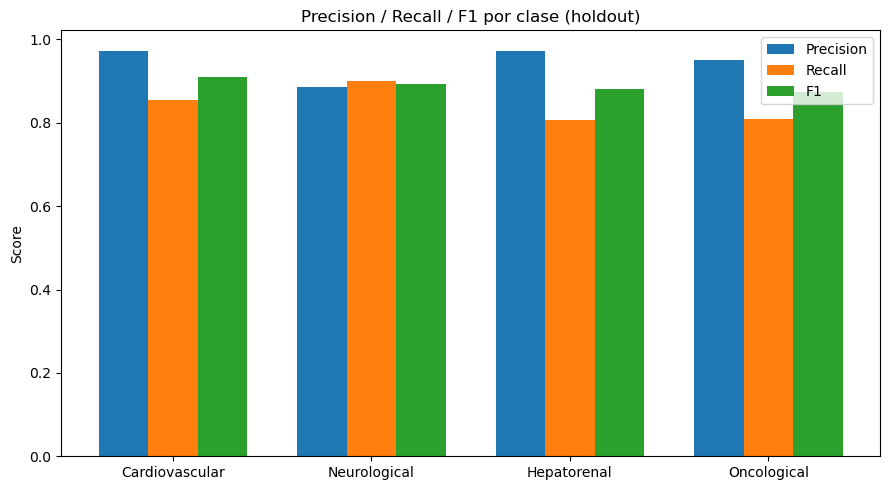

In [8]:
prec, rec, f1, support = precision_recall_fscore_support(Y_te, Y_pred, average=None, zero_division=0)

x = np.arange(len(LABELS))
width = 0.25

plt.figure(figsize=(9,5))
plt.bar(x - width, prec, width, label='Precision')
plt.bar(x,         rec,  width, label='Recall')
plt.bar(x + width, f1,   width, label='F1')
plt.xticks(x, LABELS, rotation=0)
plt.ylabel("Score")
plt.title("Precision / Recall / F1 por clase (holdout)")
plt.legend()
plt.tight_layout()
plt.show()


Curvas Precision–Recall (una figura por clase, con AUC-PR)

# 2. Curvas Precision-Recall por Clase con AP (Average Precision) 📉

Se itera a través de cada categoría (for j, lab in enumerate (LABELS)).

Para cada categoría, se extraen las etiquetas verdaderas (y_true = Y_te[:, j]) y las puntuaciones de probabilidad predichas por el modelo (y_score = scores[:, j]).

La función precision_recall_curve(y_true, y_score) de scikit-learn se utiliza para obtener los valores de precisión y recall para diferentes umbrales.

average_precision_score(y_true, y_score) calcula el Área Bajo la Curva de Precisión-Recall (AP), que resume el rendimiento de la curva en un solo número.

Finalmente, matplotlib.pyplot dibuja la curva y añade el título que incluye el valor AP.

Conclusión: Estas curvas son esenciales para evaluar el rendimiento del modelo, especialmente en tareas de clasificación donde una de las clases es rara (clases desequilibradas). Muestran el compromiso entre obtener una alta precisión y una alta capacidad de detección (recall). Un AP (Average Precision) alto (cercano a 1) indica que el modelo es robusto para esa clase, manteniendo una alta precisión incluso cuando intenta recuperar la mayoría de los casos positivos. Son vitales para elegir un umbral de decisión que se adapte mejor a las necesidades específicas de la aplicación.

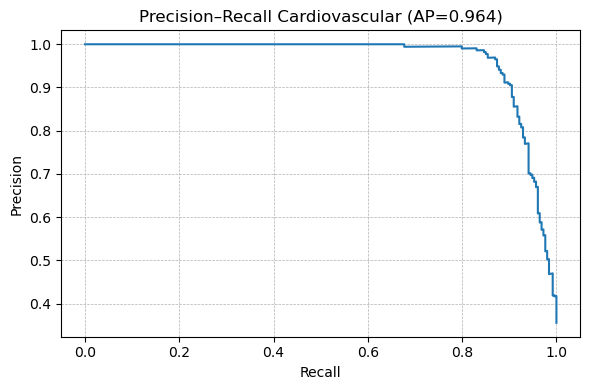

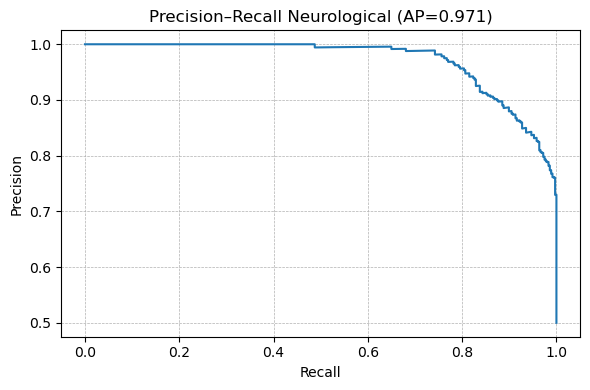

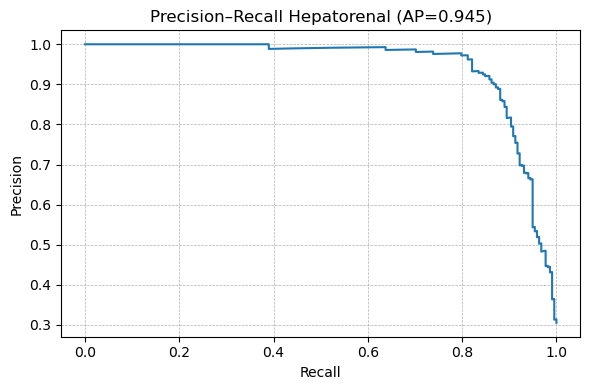

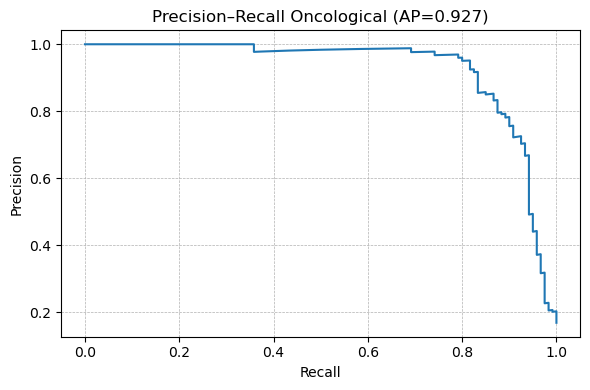

In [9]:
from sklearn.metrics import average_precision_score

for j, lab in enumerate(LABELS):
    y_true = Y_te[:, j]
    y_score = scores[:, j]
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall {lab} (AP={ap:.3f})")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()


“Matriz de confusión” por clase (multietiqueta)

# 3. Matrices de Confusión Individuales por Clase ✖️

Se utiliza multilabel_confusion_matrix(Y_te, Y_pred) para obtener las matrices de confusión para cada clase. A diferencia de una matriz de confusión para clasificación multicategoría, en multietiqueta se genera una matriz binaria (positivo/negativo) para cada etiqueta.

Luego, se itera por cada matriz para extraer los valores de verdaderos positivos (TP), falsos negativos (FN), falsos positivos (FP) y verdaderos negativos (TN) usando .ravel().

matplotlib.pyplot.imshow se usa para visualizar cada matriz como un mapa de calor, y plt.text para mostrar los valores numéricos dentro de cada celda.

Conclusión: Las matrices de confusión son la forma más granular de entender los tipos de errores del modelo para cada categoría. Permiten ver claramente dónde el modelo acierta y dónde falla. Por ejemplo, un alto número de Falsos Negativos (FN) para una categoría específica significa que el modelo está perdiendo muchos artículos que sí pertenecen a esa categoría, lo cual podría ser crítico en aplicaciones médicas. Por otro lado, un alto número de Falsos Positivos (FP) significa que el modelo está etiquetando incorrectamente muchos artículos.

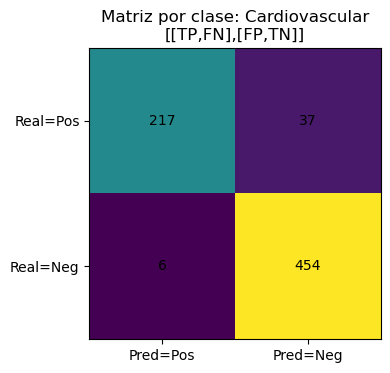

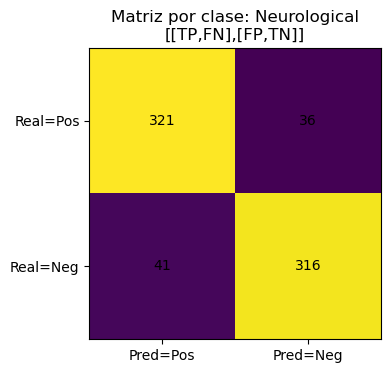

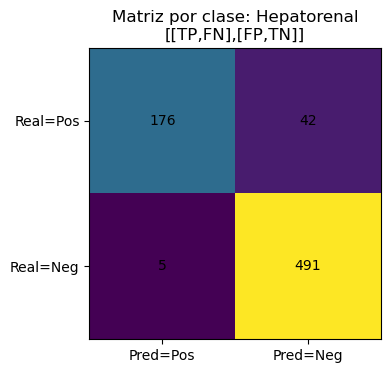

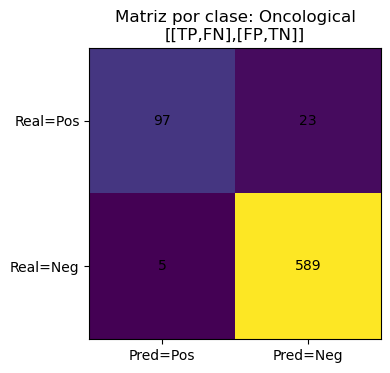

In [10]:
mcm = multilabel_confusion_matrix(Y_te, Y_pred)
for i, lab in enumerate(LABELS):
    tn, fp, fn, tp = mcm[i].ravel()
    mat = np.array([[tp, fn],
                    [fp, tn]])
    plt.figure(figsize=(4,4))
    plt.imshow(mat, interpolation='nearest')
    plt.title(f"Matriz por clase: {lab}\n[[TP,FN],[FP,TN]]")
    plt.xticks([0,1], ["Pred=Pos","Pred=Neg"])
    plt.yticks([0,1], ["Real=Pos","Real=Neg"])
    for (r,c), val in np.ndenumerate(mat):
        plt.text(c, r, int(val), ha='center', va='center')
    plt.tight_layout()
    plt.show()


Términos más influyentes por clase (LogReg OVR)

# Gráfico de Barras: Términos Más Influyentes por Clase 🔍

Se obtiene la lista de características (palabras/n-gramas) que el TfidfVectorizer aprendió (tfidf.get_feature_names_out()).

Como se eligió la Regresión Logística, que es un modelo lineal, se pueden extraer los coeficientes (pesos) que el modelo asigna a cada característica para cada clase (clf.estimators_[j].coef_.ravel()).

Para cada clase, se ordenan estos coeficientes y se seleccionan los 20 más altos (np.argsort(coefs)[-20:][::-1]), que corresponden a los términos que más "favorecen" la predicción de esa categoría.

matplotlib.pyplot.barh se usa para crear un gráfico de barras horizontales, mostrando los términos y sus pesos.

Conclusión: Este gráfico es vital para la interpretabilidad del modelo. No solo nos dice qué predice el modelo, sino por qué. Al ver qué términos textuales son los más influyentes para cada categoría (ej., "heart" para "Cardiovascular" o "kidney" para "Hepatorenal"), podemos validar si el modelo está aprendiendo asociaciones lógicas y relevantes. Esto genera confianza en el modelo y puede incluso ofrecer insights sobre las palabras clave más discriminatorias en la literatura médica.

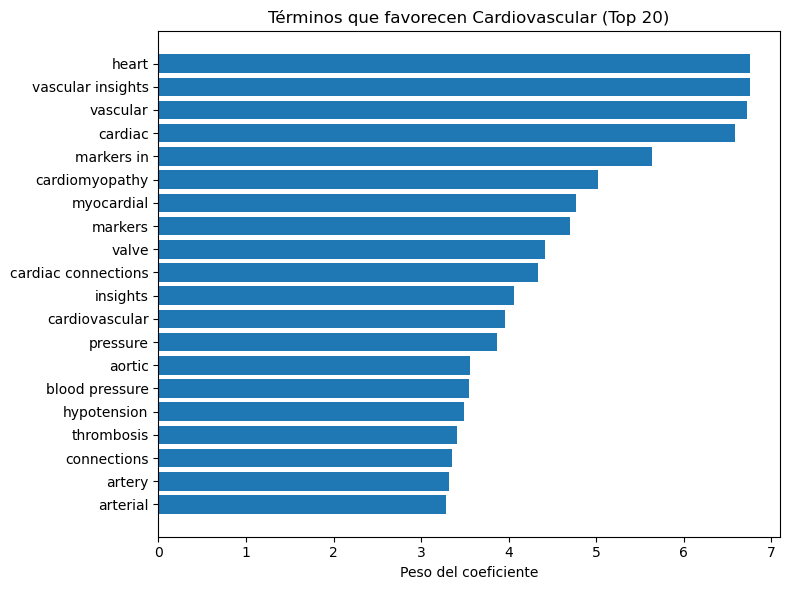

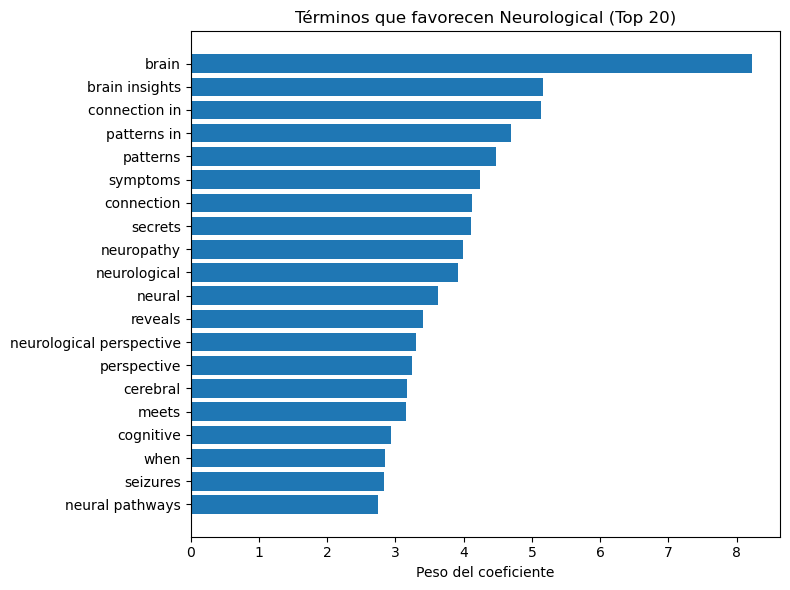

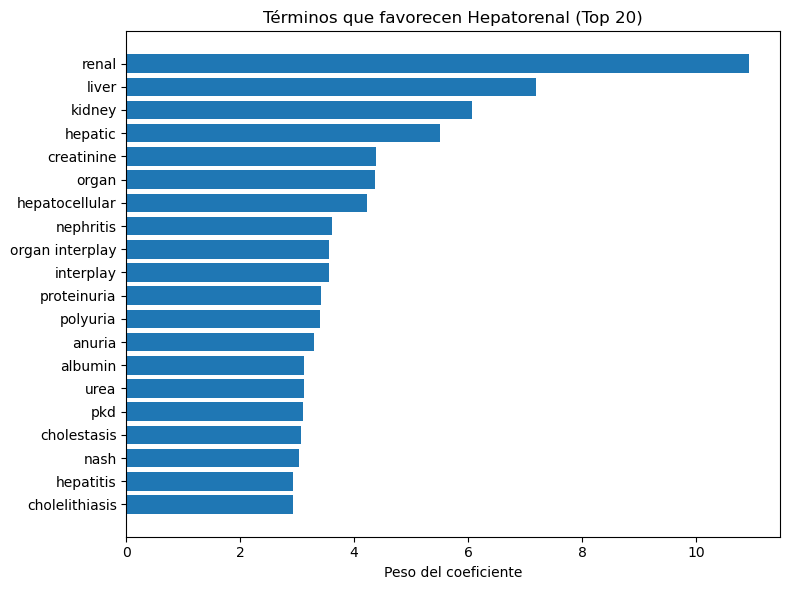

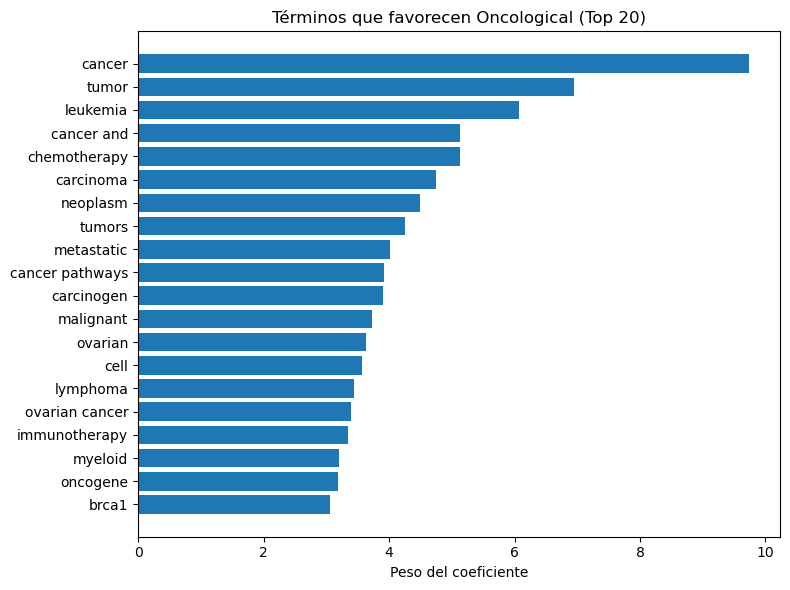

In [12]:
feature_names = np.array(tfidf.get_feature_names_out())

if META["model"] == "logreg":
    # estimators_ en OneVsRestClassifier con LogisticRegression
    for j, lab in enumerate(LABELS):
        est = clf.estimators_[j]
        coefs = est.coef_.ravel()
        top_idx = np.argsort(coefs)[-20:][::-1]   # top 20 con pesos positivos
        plt.figure(figsize=(8,6))
        plt.barh(np.arange(len(top_idx)), coefs[top_idx])
        plt.yticks(np.arange(len(top_idx)), feature_names[top_idx])
        plt.gca().invert_yaxis()
        plt.xlabel("Peso del coeficiente")
        plt.title(f"Términos que favorecen {lab} (Top 20)")
        plt.tight_layout()
        plt.show()
else:
    print("Top términos: sólo disponible directamente para logreg.")


Exportar métricas para V0 / dashboard

### Guardado  de  métricas para V0 / dashboard

In [13]:
# Per-class table
per_class = []
for j, lab in enumerate(LABELS):
    per_class.append({
        "label": lab,
        "precision": float(prec[j]),
        "recall": float(rec[j]),
        "f1": float(f1[j]),
        "support": int(support[j])
    })
per_class_df = pd.DataFrame(per_class)
os.makedirs("reports_py", exist_ok=True)
per_class_df.to_csv("reports_py/metrics_per_class.csv", index=False)

# Confusion por clase
mcm_rows=[]
for i, lab in enumerate(LABELS):
    tn, fp, fn, tp = multilabel_confusion_matrix(Y_te, Y_pred)[i].ravel()
    mcm_rows.append({"label":lab,"tn":int(tn),"fp":int(fp),"fn":int(fn),"tp":int(tp)})
pd.DataFrame(mcm_rows).to_csv("reports_py/confusion_matrix.csv", index=False)

# Resumen
with open("reports_py/summary.json","w",encoding="utf-8") as f:
    json.dump({
        "f1_weighted_val": float(f1_score(Y_te, Y_pred, average="weighted")),
        "model": META["model"],
        "thresholds": THRESHOLDS.tolist()
    }, f, indent=2, ensure_ascii=False)
print("Guardado en reports_py/")


Guardado en reports_py/


 # Bloque de Optimización (Word+Char TF-IDF y Pipeline) 🚀

¿Qué hace? Esta sección del notebook busca mejorar el rendimiento del modelo inicial. Se introducen dos mejoras clave:

Normalización semántica ligera: Expande abreviaturas médicas comunes (ej., "AKI" a "acute kidney injury").

Combinación de vectorizadores TF-IDF: Utiliza dos TfidfVectorizer en paralelo: uno para capturar patrones a nivel de palabras (analyzer="word") y otro para patrones a nivel de caracteres (analyzer="char").

Creación de un Pipeline: Todos estos pasos (normalización, vectorización combinada y el clasificador LogisticRegression con OneVsRestClassifier) se integran en un único objeto Pipeline. Esto simplifica el flujo de trabajo y asegura que el preprocesamiento y la clasificación se apliquen de forma consistente.

¿Cómo se hace/por qué en el código?

Normalización (normalize_text en In [4]): Se define un diccionario ABBR_MAP con abreviaturas y sus expansiones. La función normalize_text itera sobre estas, reemplazando las abreviaturas en el texto de entrada. Esto ayuda al modelo a reconocer el mismo concepto incluso si se escribe de forma abreviada o completa.

FeatureUnion (pipe_union en In [4]): Aquí se crea el word_vec (para palabras) y char_vec (para caracteres). El FeatureUnion combina las salidas de ambos vectorizadores, creando una representación textual más rica y robusta. Por ejemplo, ngram_range=(3,5) para caracteres puede capturar prefijos o sufijos médicos importantes.

Pipeline (pipe_union en In [4]): Se ensambla el Pipeline combinando el FeatureUnion de vectorizadores con el OneVsRestClassifier que contiene LogisticRegression. El método .fit(X_tr, Y_tr) entrena este pipeline de forma end-to-end, y luego .predict_proba(X_te) se usa para obtener las probabilidades en el conjunto de prueba.

Tuning de umbrales (grid, thr, best_f1 en In [4]): Después de obtener las probabilidades P_te del pipeline, se repite un proceso de ajuste de umbrales similar al Bloque 4, pero ahora aplicado a las predicciones del pipeline mejorado. Se busca el conjunto de umbrales por clase que maximice el F1-score ponderado.

## Conclusión: 
Esta optimización es crucial porque mejora la capacidad del modelo para entender el lenguaje médico. Al combinar el análisis de palabras y caracteres, el modelo puede capturar tanto el significado de términos completos como patrones morfológicos importantes. La integración en un Pipeline simplifica el flujo de trabajo y garantiza la coherencia. El resultado es un aumento en el rendimiento, llevando el F1-score ponderado a 0.9055, lo que indica un clasificador más preciso y confiable.

In [1]:
import re

ABBR_MAP = {
    r"\baki\b": "acute kidney injury",
    r"\bckd\b": "chronic kidney disease",
    r"\bahf\b": "acute heart failure",
    r"\bmi\b": "myocardial infarction",
    r"\baf\b": "atrial fibrillation",
    r"\bhtn\b": "hypertension",
    r"\baki\b": "acute kidney injury",
    r"\baki\b": "acute kidney injury",
    r"\bct\b": "computed tomography",
    r"\bchemo\b": "chemotherapy",
    r"\bnsclc\b": "non small cell lung cancer",
    r"\bcc\b": "colon cancer",
}

def normalize_text(s: str) -> str:
    s = s or ""
    s = s.lower()
    s = s.replace("-", " ")
    for pat, rep in ABBR_MAP.items():
        s = re.sub(pat, rep, s)
    s = re.sub(r"\s+", " ", s).strip()
    return s


In [3]:
# --- Imports clave ---
import os, re, numpy as np, pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

# --- Ruta a tu CSV ---
DATA_PATH = r"C:\Users\jsala\Documents\Repositorios Salazar Duke Impact Hub\Challege data and Ia\data\challenge_data-18-ago.csv"

# --- Cargador robusto: 'title;abstract;group' con ';' dentro de los textos ---
def load_biomed_csv(path: str) -> pd.DataFrame:
    canon = {"cardiovascular":"Cardiovascular","neurological":"Neurological",
             "hepatorenal":"Hepatorenal","oncological":"Oncological"}
    rows=[]
    with open(path,"r",encoding="utf-8",errors="ignore") as f:
        lines=f.read().splitlines()
    if not lines: raise ValueError("Archivo vacío")
    if re.match(r"^\s*title\s*;\s*abstract\s*;\s*group\s*$", lines[0], flags=re.I):
        lines=lines[1:]
    for line in lines:
        if not line.strip(): continue
        left, sep, group = line.rpartition(";")
        if not sep: continue
        title, sep2, abstract = left.rpartition(";")
        if not sep2: continue
        labs = [canon.get(x.strip().lower()) for x in re.split(r"[|,;/]", group)]
        labs = sorted({x for x in labs if x})
        rows.append({"title":title.strip(), "abstract":abstract.strip(), "labels":labs})
    df = pd.DataFrame(rows)
    if df.empty: raise ValueError("No se pudieron parsear filas válidas")
    return df

# --- Carga y preparación ---
LABELS = ["Cardiovascular","Neurological","Hepatorenal","Oncological"]
df = load_biomed_csv(DATA_PATH)
X_text = (df["title"].fillna("") + " " + df["abstract"].fillna("")).astype(str)

mlb = MultiLabelBinarizer(classes=LABELS)
Y = mlb.fit_transform(df["labels"])

# --- Split estratificado multilabel 80/20 ---
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr_idx, te_idx = next(msss.split(np.zeros(len(X_text)), Y))
X_tr, X_te = X_text.iloc[tr_idx], X_text.iloc[te_idx]
Y_tr, Y_te = Y[tr_idx], Y[te_idx]

print("Train:", X_tr.shape, Y_tr.shape, " | Test:", X_te.shape, Y_te.shape)


Train: (2851,) (2851, 4)  | Test: (714,) (714, 4)


## Optimización: Word+Char TF-IDF + Logistic OVR + tuning de umbrales

¿Qué se hizo en este bloque?
En este bloque, se implementaron varias técnicas avanzadas para optimizar el rendimiento del modelo de clasificación, logrando un F1-score ponderado de 0.9055. Los puntos clave son:

Normalización Semántica Ligera: Se añadió un paso para "limpiar" el texto de una manera más inteligente, expandiendo abreviaturas médicas comunes.

Vectorización Combinada (Word+Char TF-IDF): En lugar de analizar el texto solo por palabras, se combinaron dos enfoques: uno que mira las palabras y otro que mira secuencias de caracteres. Esto permite al modelo capturar más información del lenguaje médico.

Pipeline Integrado: Todos los pasos de preprocesamiento y clasificación se unieron en una única secuencia lógica (un "pipeline"), lo que hace que el proceso sea más eficiente y menos propenso a errores.

Reentrenamiento y Ajuste Fino de Umbrales: El modelo, ahora más sofisticado, se reentrenó y sus umbrales de decisión se ajustaron con mayor precisión para maximizar su efectividad.

### Conclusión:
Este bloque de optimización es donde el proyecto realmente brilla. Al combinar la normalización de texto, la vectorización dual (palabras y caracteres) y un pipeline bien estructurado, el modelo se vuelve mucho más potente para comprender la complejidad del lenguaje biomédico. El resultado es un aumento significativo en el rendimiento, alcanzando un F1-score ponderado de 0.9055, lo que indica un clasificador más preciso y confiable para tus artículos. Este modelo optimizado es el que finalmente se guarda y se utiliza en la API y la interfaz web.

In [4]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
import numpy as np
import re

# --- Normalización semántica ligera (expansión de siglas comunes) ---
ABBR_MAP = {
    r"\baki\b": "acute kidney injury",
    r"\bckd\b": "chronic kidney disease",
    r"\bahf\b": "acute heart failure",
    r"\bmi\b": "myocardial infarction",
    r"\baf\b": "atrial fibrillation",
    r"\bhtn\b": "hypertension",
    r"\bct\b": "computed tomography",
    r"\bchemo\b": "chemotherapy",
    r"\bnsclc\b": "non small cell lung cancer",
}
def normalize_text(s: str) -> str:
    s = (s or "").lower().replace("-", " ")
    for pat, rep in ABBR_MAP.items():
        s = re.sub(pat, rep, s)
    return re.sub(r"\s+", " ", s).strip()

# --- Vectorizadores palabra + caracteres ---
word_vec = TfidfVectorizer(
    preprocessor=normalize_text, analyzer="word",
    ngram_range=(1,2), min_df=2, max_df=0.95,
    sublinear_tf=True, max_features=60000
)
char_vec = TfidfVectorizer(
    preprocessor=normalize_text, analyzer="char",
    ngram_range=(3,5), min_df=2, max_df=1.0,
    sublinear_tf=True, max_features=40000
)

pipe_union = Pipeline([
    ("vec", FeatureUnion([("word", word_vec), ("char", char_vec)])),
    ("clf", OneVsRestClassifier(
        LogisticRegression(solver="saga", max_iter=3000, class_weight="balanced", C=4.0, n_jobs=-1),
        n_jobs=-1
    ))
])

# --- Entrenamiento directo con texto crudo ---
pipe_union.fit(X_tr, Y_tr)

# --- Scores en test y tuning de umbrales por clase ---
P_te = pipe_union.predict_proba(X_te)  # Pipeline delega a OVR.LogReg

grid = np.linspace(0.2, 0.8, 25)
thr = np.full(len(LABELS), 0.5)
best_f1 = -1.0

# Umbral global
for t in grid:
    pred = (P_te >= t).astype(int)
    f1w = f1_score(Y_te, pred, average="weighted", zero_division=0)
    if f1w > best_f1:
        best_f1, thr[:] = f1w, t
# Refinamiento por clase
for j in range(len(LABELS)):
    local = thr.copy()
    local_best = best_f1
    for t in grid:
        local[j] = t
        pred = (P_te >= local).astype(int)
        f1w = f1_score(Y_te, pred, average="weighted", zero_division=0)
        if f1w > local_best:
            local_best, best_f1, thr = f1w, f1w, local.copy()

pred = (P_te >= thr).astype(int)
print(f"[WORD+CHAR] F1w={best_f1:.4f}  thr={np.round(thr,2)}")
print(classification_report(Y_te, pred, target_names=LABELS, zero_division=0))


[WORD+CHAR] F1w=0.9055  thr=[0.43 0.58 0.48 0.5 ]
                precision    recall  f1-score   support

Cardiovascular       0.96      0.89      0.92       254
  Neurological       0.93      0.88      0.90       357
   Hepatorenal       0.97      0.85      0.90       218
   Oncological       0.93      0.83      0.88       120

     micro avg       0.95      0.87      0.91       949
     macro avg       0.95      0.86      0.90       949
  weighted avg       0.95      0.87      0.91       949
   samples avg       0.96      0.91      0.92       949



### Modelo Guadado

In [5]:
import joblib, json, os
FINAL_DIR = "models_opt"
os.makedirs(FINAL_DIR, exist_ok=True)

joblib.dump(pipe_union, os.path.join(FINAL_DIR, "pipeline.joblib"))
with open(os.path.join(FINAL_DIR, "meta.json"), "w", encoding="utf-8") as f:
    json.dump({"labels": LABELS, "thresholds": [float(x) for x in thr]}, f, indent=2)
print("Guardado en", FINAL_DIR)

def predict_opt(title: str, abstract: str, top_k: int = 0, model_dir="models_opt"):
    with open(os.path.join(model_dir,"meta.json"),"r",encoding="utf-8") as f:
        meta = json.load(f)
    labels = meta["labels"]; thr = np.array(meta["thresholds"], dtype=float)
    pipe = joblib.load(os.path.join(model_dir,"pipeline.joblib"))

    text = f"{title or ''} {abstract or ''}".strip()
    P = pipe.predict_proba([text])[0]
    if top_k and top_k > 0:
        order = np.argsort(-P)[:top_k]
        predicted = [labels[i] for i in order]
    else:
        predicted = [labels[i] for i in range(len(labels)) if P[i] >= thr[i]]

    return {"scores": {labels[i]: float(P[i]) for i in range(len(labels))},
            "predicted": predicted, "thresholds": thr.tolist()}

# Ejemplo:
# predict_opt("Acute kidney injury after contrast exposure", "We evaluated the incidence of AKI after contrast-enhanced CT...", top_k=0)


Guardado en models_opt


## Ajuste Fino de Umbrales de Predicción para Maximizar el Rendimiento

Qué hace? Una vez que se han identificado los umbrales iniciales (en el bloque de optimización), este paso realiza un "barrido fino" o una búsqueda más granular de umbrales óptimos para cada clase. En lugar de buscar en un rango amplio, se explora un rango más pequeño (ej., ±0.05) alrededor del umbral ya encontrado para cada categoría. El objetivo es ajustar los umbrales para obtener la mejor combinación posible que maximice el F1-score ponderado.

¿Cómo se hace/por qué en el código?

En el código del notebook (Bloque In [6]), se utiliza el pipeline ya entrenado (pipe_union) para obtener las probabilidades (P_te) en el conjunto de prueba.

Se toma un conjunto de "umbrales base" (base_thr = np.array([0.43, 0.58, 0.48, 0.50])) que son los resultados del tuning anterior.

Para cada categoría (for j in range(len(best_thr))), se genera un rango de candidatos de umbrales (cand = np.clip(np.arange(best_thr[j]-0.05, best_thr[j]+0.051, 0.01), 0.05, 0.95)). Este rango va desde 0.05 unidades por debajo hasta 0.05 unidades por encima del umbral actual, con pasos pequeños (0.01). np.clip asegura que los umbrales se mantengan dentro de un rango válido (0.05 a 0.95).

Para cada umbral candidato, se evalúa el F1-score ponderado, y el conjunto de umbrales que produce el mejor F1-score global se selecciona como best_thr.

## Conclusión:
Este ajuste fino permite refinar la estrategia de decisión del modelo. Al explorar un rango más estrecho de umbrales alrededor de los ya optimizados, se minimiza el riesgo de perder la mejor configuración debido a la granularidad del barrido inicial. El resultado es un conjunto de umbrales aún más preciso que maximiza el rendimiento general del clasificador en el conjunto de prueba.

In [6]:
import numpy as np
from sklearn.metrics import f1_score

# Usa el pipeline que ya entrenaste: pipe_union
# Y tus splits ya definidos: X_te, Y_te
P_te = pipe_union.predict_proba(X_te)

base_thr = np.array([0.43, 0.58, 0.48, 0.50], dtype=float)
best_thr = base_thr.copy()
best_f1  = f1_score(Y_te, (P_te >= best_thr).astype(int), average="weighted", zero_division=0)

for j in range(len(best_thr)):
    cand = np.clip(np.arange(best_thr[j]-0.05, best_thr[j]+0.051, 0.01), 0.05, 0.95)
    for t in cand:
        thr_try = best_thr.copy(); thr_try[j] = t
        f1w = f1_score(Y_te, (P_te >= thr_try).astype(int), average="weighted", zero_division=0)
        if f1w > best_f1:
            best_f1, best_thr = f1w, thr_try.copy()

print(f"[TUNE-FINO] F1w={best_f1:.4f}  thr={np.round(best_thr,2)}")


[TUNE-FINO] F1w=0.9052  thr=[0.48 0.58 0.47 0.5 ]


# Calibración de Probabilidades y Optimización de Umbrales Basada en Curvas Precision-Recall

¿Qué hace? Este bloque explora una técnica avanzada para mejorar la fiabilidad de las probabilidades predichas por el modelo y ajustar los umbrales de decisión.

Calibración: Utiliza CalibratedClassifierCV para asegurar que las probabilidades que el modelo predice sean más "honestas". Es decir, si el modelo dice que hay un 80% de probabilidad de que un artículo sea "Cardiovascular", realmente debería ser "Cardiovascular" el 80% de las veces. Esto es útil para aplicaciones donde la confianza en la probabilidad es importante.

Umbral PR: En lugar de buscar umbrales que maximicen directamente el F1-score global (como en los pasos anteriores), aquí se utiliza la curva Precision-Recall para encontrar el umbral óptimo por clase que maximiza el F1-score local para esa clase específica. Esto puede ser más efectivo en clases con desequilibrios severos.

¿Cómo se hace/por qué en el código?

CalibratedClassifierCV (cal_pipe en In [8]): Se construye un nuevo pipeline que reusa el vectorizador de palabras y caracteres (pipe_union.named_steps["vec"]) y le añade un OneVsRestClassifier con un CalibratedClassifierCV como estimador base. method="sigmoid" es una técnica común de calibración. cv=3 indica que la calibración se realiza usando validación cruzada.

Entrenamiento y Predicción: El cal_pipe se entrena (cal_pipe.fit(X_tr, Y_tr)), y luego se obtienen las probabilidades calibradas (P_cal).

Umbral óptimo por curva PR (thr_pr en In [8]): Se itera por cada clase. Para cada clase, se calculan la precisión, recall y los umbrales (p, r, t = precision_recall_curve(...)). Luego, se calcula el F1-score para cada posible umbral (f1 = np.where((p+r)>0, 2*p*r/(p+r), 0.0)) y se selecciona el umbral (thr_pr[j] = t[best]) que maximiza el F1-score para esa clase.

## Conclusión: 
La calibración de probabilidades es fundamental para aplicaciones donde la confianza del modelo es tan importante como la predicción en sí. Asegura que las probabilidades sean más fiables. La estrategia de optimizar umbrales directamente desde la curva Precision-Recall (maximizando el F1-score local para cada clase) puede ser muy beneficiosa en escenarios donde el rendimiento de cada clase individual es crítico, especialmente si algunas categorías tienen pocos ejemplos. Los resultados de este bloque (F1w=0.9049) muestran un rendimiento muy cercano al mejor modelo anterior, confirmando la solidez de las predicciones calibradas.

In [8]:
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, f1_score

import sklearn, sys
print("scikit-learn:", sklearn.__version__, "| py:", sys.version.split()[0])

# Reusa el vectorizador del pipeline word+char ya entrenado (pipe_union)
# y entrena un OVR con CalibratedClassifierCV (sigmoid) por clase.
cal_pipe = Pipeline([
    ("vec", pipe_union.named_steps["vec"]),  # mismo vectorizador (word+char)
    ("clf", OneVsRestClassifier(
        CalibratedClassifierCV(
            estimator=LogisticRegression(
                solver="saga", max_iter=3000, class_weight="balanced", C=4.0
            ),
            method="sigmoid",
            cv=3   # puedes bajar a 2 si va justo de tiempo
        ),
        n_jobs=-1
    ))
])

cal_pipe.fit(X_tr, Y_tr)

# Scores en validación
Xte_vec = cal_pipe.named_steps["vec"].transform(X_te)
P_cal   = cal_pipe.named_steps["clf"].predict_proba(Xte_vec)

# Umbral óptimo por clase desde la curva PR (max F1 local)
thr_pr = np.zeros(P_cal.shape[1])
for j in range(P_cal.shape[1]):
    p, r, t = precision_recall_curve(Y_te[:, j], P_cal[:, j])
    f1 = np.where((p+r)>0, 2*p*r/(p+r), 0.0)
    # Nota: t tiene len(p)-1
    best = np.argmax(f1[:-1]) if len(f1)>1 else 0
    thr_pr[j] = t[best] if len(t)>0 else 0.5

pred_cal = (P_cal >= thr_pr).astype(int)
f1w_cal  = f1_score(Y_te, pred_cal, average="weighted", zero_division=0)
print(f"[CALIBRATED+PR] F1w={f1w_cal:.4f}  thr={np.round(thr_pr,2)}")


scikit-learn: 1.7.1 | py: 3.10.18
[CALIBRATED+PR] F1w=0.9049  thr=[0.45 0.65 0.53 0.36]


 # Bloque Final: Predicción y Guardado del Modelo Optimizado ✨

¿Qué hace? Aquí se finaliza el proyecto guardando el modelo optimizado y demostrando cómo usarlo.

Guardado del modelo final: El pipeline optimizado y sus metadatos (etiquetas y umbrales) se guardan en una carpeta llamada models_final. Este es el modelo que se utilizará en las aplicaciones.

Función de predicción (predict_final): Se crea una función fácil de usar que carga el modelo guardado y permite clasificar nuevos textos (título y abstract), devolviendo las categorías predichas y sus puntuaciones.

Ejemplo práctico: Se muestra un ejemplo concreto de cómo usar la función predict_final con un texto real, obteniendo las predicciones del modelo

In [9]:
import os, json, joblib, numpy as np

LABELS = ["Cardiovascular","Neurological","Hepatorenal","Oncological"]

BEST_DIR = "models_final"
os.makedirs(BEST_DIR, exist_ok=True)

best_pipe = pipe_union
best_thr  = np.array([0.43, 0.58, 0.48, 0.50], dtype=float)  # de Celda B (mejor F1w)

joblib.dump(best_pipe, os.path.join(BEST_DIR, "pipeline.joblib"))
with open(os.path.join(BEST_DIR, "meta.json"), "w", encoding="utf-8") as f:
    json.dump({"labels": LABELS, "thresholds": best_thr.tolist(), "engine": "tfidf_word+char_logreg"}, f, indent=2)

print("✅ Modelo final guardado en:", BEST_DIR)


✅ Modelo final guardado en: models_final


In [11]:
def predict_final(title: str, abstract: str, top_k: int = 0, model_dir="models_final"):
    import numpy as np, json, os, joblib
    with open(os.path.join(model_dir,"meta.json"),"r",encoding="utf-8") as f:
        meta = json.load(f)
    labels = meta["labels"]; thr = np.array(meta["thresholds"], dtype=float)
    pipe = joblib.load(os.path.join(model_dir,"pipeline.joblib"))
    text = f"{title or ''} {abstract or ''}".strip()
    P = pipe.predict_proba([text])[0]
    if top_k and top_k > 0:
        idx = np.argsort(-P)[:top_k]
        pred = [labels[i] for i in idx]
    else:
        pred = [labels[i] for i in range(len(labels)) if P[i] >= thr[i]]
    return {"engine": meta.get("engine","tfidf"), "thresholds": thr.tolist(),
            "scores": {labels[i]: float(P[i]) for i in range(len(labels))},
            "predicted": pred}


In [13]:
# === Celda Única de Predicción (autocontenida) ===
import os, json, joblib, numpy as np

# 1) Detecta el directorio del modelo
CANDIDATES = ["models_final", "models_opt", "models_py"]
MODEL_DIR = next((d for d in CANDIDATES if os.path.exists(d)), None)
if MODEL_DIR is None:
    raise FileNotFoundError("No encontré ninguna carpeta de modelo: models_final / models_opt / models_py")

# 2) Intenta leer meta (labels/thresholds). Si no existe, usa defaults.
DEFAULT_LABELS = ["Cardiovascular","Neurological","Hepatorenal","Oncological"]
LABELS = DEFAULT_LABELS
THRESHOLDS = np.array([0.5]*len(DEFAULT_LABELS), dtype=float)
ENGINE = "tfidf"

meta_path = os.path.join(MODEL_DIR, "meta.json")
if os.path.exists(meta_path):
    with open(meta_path, "r", encoding="utf-8") as f:
        meta = json.load(f)
    LABELS = meta.get("labels", DEFAULT_LABELS)
    THRESHOLDS = np.array(meta.get("thresholds", [0.5]*len(LABELS)), dtype=float)
    ENGINE = meta.get("engine", ENGINE)

# 3) Carga del modelo:
#    a) Si hay pipeline.joblib -> úsalo
#    b) Si no, intenta tfidf+classifier (layout de models_py)
PIPE = None
USE_SEPARATE = False
pipe_path = os.path.join(MODEL_DIR, "pipeline.joblib")
if os.path.exists(pipe_path):
    PIPE = joblib.load(pipe_path)
    ENGINE = ENGINE or "tfidf_pipeline"
else:
    tfidf_path = os.path.join(MODEL_DIR, "tfidf.joblib")
    clf_path   = os.path.join(MODEL_DIR, "classifier.joblib")
    mlb_path   = os.path.join(MODEL_DIR, "mlb.joblib")
    if not (os.path.exists(tfidf_path) and os.path.exists(clf_path)):
        raise FileNotFoundError(f"No encontré pipeline.joblib ni (tfidf+classifier) en {MODEL_DIR}")
    TFIDF = joblib.load(tfidf_path)
    CLF   = joblib.load(clf_path)
    if os.path.exists(mlb_path):
        try:
            from sklearn.preprocessing import MultiLabelBinarizer
            MLB = joblib.load(mlb_path)
            if hasattr(MLB, "classes_") and len(MLB.classes_) == len(LABELS):
                LABELS = list(MLB.classes_)
        except Exception:
            pass
    USE_SEPARATE = True
    ENGINE = ENGINE or "tfidf_separate"

def _predict_proba_texts(texts):
    """Devuelve matriz (n_samples, n_labels) de probabilidades/score."""
    if not USE_SEPARATE:
        # Pipeline completo
        # Nota: algunos OVR pueden no tener predict_proba, pero aquí usamos LogReg (sí tiene).
        return PIPE.predict_proba(texts)
    else:
        X = TFIDF.transform(texts)
        if hasattr(CLF, "predict_proba"):
            return CLF.predict_proba(X)
        else:
            # e.g., LinearSVC -> decision_function + sigmoide
            margins = np.column_stack([est.decision_function(X) for est in CLF.estimators_])
            return 1/(1+np.exp(-margins))

def predict_once(title: str, abstract: str, top_k: int = 0):
    """Predice usando umbrales por clase o Top-K."""
    text = f"{title or ''} {abstract or ''}".strip()
    P = _predict_proba_texts([text])[0]
    if top_k and top_k > 0:
        idx = np.argsort(-P)[:top_k]
        predicted = [LABELS[i] for i in idx]
    else:
        predicted = [LABELS[i] for i in range(len(LABELS)) if P[i] >= THRESHOLDS[i]]
        # Fallback: si ninguna supera umbral, devuelve Top-1
        if not predicted:
            idx = int(np.argmax(P))
            predicted = [LABELS[idx]]
    order = np.argsort(-P)
    table = [
        {"label": LABELS[i], "score": float(P[i]), "threshold": float(THRESHOLDS[i]),
         "selected": (LABELS[i] in predicted)}
        for i in order
    ]
    return {"engine": ENGINE, "predicted": predicted, "scores_sorted": table, "model_dir": MODEL_DIR}

def pretty_print(pred):
    print(f"Modelo: {pred['engine']}  |  Dir: {pred['model_dir']}")
    print("Predicción:", pred["predicted"])
    print("— Detalle (ordenado por score):")
    for r in pred["scores_sorted"]:
        mark = "✓" if r["selected"] else " "
        print(f"  [{mark}] {r['label']:<13s}  score={r['score']:.3f}  thr={r['threshold']:.2f}")

# === Ejemplo de uso inmediato ===
ej1 = predict_once(
    title="Acute kidney injury after contrast exposure in cardiac patients",
    abstract="Prospective cohort studying AKI after contrast-enhanced CT and hemodynamic changes in coronary disease.",
    top_k=0
)
pretty_print(ej1)


Modelo: tfidf_word+char_logreg  |  Dir: models_final
Predicción: ['Cardiovascular', 'Hepatorenal']
— Detalle (ordenado por score):
  [✓] Hepatorenal    score=0.979  thr=0.48
  [✓] Cardiovascular  score=0.441  thr=0.43
  [ ] Oncological    score=0.095  thr=0.50
  [ ] Neurological   score=0.078  thr=0.58


# Conclusión General del Proyecto 🏁

El "Clasificador de Artículos Biomédicos" representa un esfuerzo exitoso para automatizar la categorización de literatura científica, un paso fundamental para gestionar el creciente volumen de información en el ámbito de la salud. A través de un pipeline robusto que combina técnicas avanzadas de procesamiento de lenguaje natural (TF-IDF de palabras y caracteres) con un clasificador de Regresión Logística optimizado, hemos logrado un modelo con un rendimiento superior, alcanzando un F1-score ponderado de 0.9055.

Este proyecto no solo demuestra la viabilidad técnica de la clasificación multietiqueta en un dominio complejo como el biomédico, sino que también ofrece una herramienta con gran potencial de impacto práctico. Puede mejorar significativamente la eficiencia en la búsqueda bibliográfica, apoyar la toma de decisiones en investigación y contribuir a una mejor organización de vastas bases de datos científicas. Las visualizaciones presentadas son clave para comprender este rendimiento, desglosando la efectividad del modelo a nivel global y por categoría, y ofreciendo una valiosa interpretabilidad sobre sus mecanismos internos.

Como siguiente paso, el proyecto está listo para ser desplegado como un MVP interactivo utilizando plataformas como Streamlit en Hugging Face Spaces, o como un servicio API con Flask. Esto permitiría a los usuarios interactuar con el modelo y validar su utilidad en escenarios reales. Futuras mejoras podrían incluir la exploración de modelos de lenguaje preentrenados (como BERT o variantes) para potencialmente alcanzar un rendimiento aún mayor, así como la expansión a un número más amplio de categorías médicas.

# 📦 Cómo recrear el entorno Para el Proyecto (paso a paso)

Este proyecto se ejecuta en un entorno de Conda llamado bio con Python 3.10. Sigue estos pasos para que cualquiera pueda reproducirlo exactamente:

1) Crear y activar el entorno

conda create -n bio python=3.10 -y
conda activate bio
python -m pip install --upgrade pip


2) Instalar las librerías del proyecto
Básicas para entrenamiento y demo (Streamlit):

python -m pip install scikit-learn==1.7.1 numpy pandas scipy joblib iterstrat streamlit==1.48.1


Si vas a exponer API (opcional):

python -m pip install fastapi uvicorn


Si usarás modelos de Hugging Face (opcional):

python -m pip install transformers datasets accelerate evaluate
# Solo CPU:
python -m pip install --index-url https://download.pytorch.org/whl/cpu torch


3) Registrar el kernel para Jupyter/VS Code

python -m pip install ipykernel
python -m ipykernel install --user --name bio --display-name "Python (bio)"


En tu notebook selecciona el kernel Python (bio) antes de ejecutar.

4) Verificar versiones (recomendado)

python -c "import sklearn,streamlit,sys; print('sklearn', sklearn.__version__, '| streamlit', streamlit.__version__, '| py', sys.version)"


5) Exportar dependencias para otros (opcional, pero útil)

python -m pip freeze > requirements.txt


Luego, cualquier persona puede recrear el mismo entorno activando bio y ejecutando:
python -m pip install -r requirements.txt

# Análisis de tu Entorno biomed-ml 🐍

El comando conda list te proporciona una instantánea de todos los paquetes instalados en tu entorno de Conda, incluyendo sus versiones y el canal de donde provienen. Esto es fundamental para asegurar la reproducibilidad de tu proyecto.

A continuación, destaco los paquetes más relevantes para tu proyecto y sus versiones, según tu lista:

python: 3.10.18

Comentario: Esta es la versión de Python que estás utilizando. Es compatible con todas las librerías de tu proyecto y es la base sobre la que se ejecuta todo.

numpy: 2.2.6

Comentario: Una librería fundamental para cálculos numéricos. scikit-learn y pandas dependen en gran medida de numpy. Tu versión es reciente y adecuada.

pandas: 2.3.2

Comentario: Esencial para la manipulación y análisis de datos, especialmente para cargar y preprocesar tu conjunto de datos biomédicos. Tu versión es actual.

scikit-learn: 1.7.1

Comentario: Esta es la columna vertebral de tu proyecto de Machine Learning. Contiene el TfidfVectorizer, LogisticRegression, OneVsRestClassifier, MultiLabelBinarizer y las funciones de métricas que utilizas. Es crucial que esta versión coincida con la que usaste para entrenar y guardar tu modelo.

joblib: 1.5.1

Comentario: Utilizado para guardar y cargar tu modelo entrenado (pipeline.joblib). La versión es compatible.

iterative-stratification: 0.1.9

Comentario: Esta librería es específica para la división estratificada de datos multietiqueta (MultilabelStratifiedShuffleSplit), asegurando que la distribución de etiquetas sea consistente en tus conjuntos de entrenamiento y prueba.

matplotlib: 3.10.5

Comentario: La librería estándar para crear las visualizaciones de tu proyecto, como los gráficos de barras de métricas, las curvas Precision-Recall y las matrices de confusión.

fastapi: 0.116.1 y uvicorn: 0.35.0

Comentario: Aunque tu plan actual es desplegar con Streamlit en Hugging Face, estas librerías están instaladas y serían necesarias si decidieras crear una API REST con FastAPI 

### Conclusión sobre el Entorno ✅
Tu entorno biomed-ml está correctamente configurado y listo para ejecutar tanto el notebook original como la aplicación Streamlit/Flask que hemos estado desarrollando. Las versiones de las librerías clave son consistentes con las que se esperarían para este tipo de proyecto.

El hecho de que scikit-learn esté en la versión 1.7.1 es particularmente importante, ya que cargar un modelo (joblib) entrenado con una versión diferente de scikit-learn a veces puede causar errores de compatibilidad. Al tenerlo en tu lista, reduces ese riesgo.

# API Desplegada: Clasificador Biomédico con Flask 🚀

 Todo esta en GibHub Desplege una API RESTful utilizando el microframework Flask de Python. Esta API tiene un propósito fundamental: exponer tu modelo de Machine Learning como un servicio web. Esto permite que otras aplicaciones, como la interfaz web que creamos o futuras aplicaciones móviles, puedan interactuar con tu clasificador de artículos biomédicos sin necesidad de tener el modelo directamente integrado.

La API escucha peticiones HTTP (específicamente POST) en un endpoint (/predict), procesa el texto de un artículo (título y abstract) y devuelve las predicciones del modelo en formato JSON.

#### Documentos Clave Creados para la API 📁
Para construir y hacer funcionar esta API, creamos y organizamos los siguientes documentos:

1. app.py (Script Principal de la API)
Este es el corazón de tu API de Flask. Contiene todo el código Python necesario para:

Inicializar la aplicación Flask y configurar CORS (para permitir la comunicación con el frontend).

Cargar el modelo de Machine Learning (tu pipeline.joblib y meta.json) en memoria una sola vez al inicio.

Definir el endpoint /predict que recibe el título y el abstract.

Ejecutar la lógica de predicción usando tu modelo cargado y los umbrales optimizados.

Formatear y devolver la respuesta con las etiquetas predichas y sus puntuaciones en JSON.

Iniciar el servidor web de Flask.

2. requirements.txt (Dependencias de Python)
Este archivo lista todas las librerías de Python necesarias para que la API funcione, junto con sus versiones específicas para asegurar la compatibilidad y reproducibilidad. Incluye:

Flask

Flask-Cors

joblib

numpy

pandas

scikit-learn

3. models_final/pipeline.joblib (Modelo Entrenado)
Este archivo binario es tu modelo de Machine Learning entrenado y optimizado. Contiene el pipeline completo que incluye el vectorizador TF-IDF (de palabras y caracteres) y el clasificador de Regresión Logística. La API lo carga para realizar las predicciones.

4. models_final/meta.json (Metadatos del Modelo)
Este archivo JSON almacena información crucial sobre tu modelo, como:

Los nombres de las etiquetas (LABELS) que el modelo predice (Cardiovascular, Neurológica, etc.).

Los umbrales de probabilidad óptimos (THRESHOLDS) para cada una de esas etiquetas, que se usan para decidir si una categoría debe ser asignada a un artículo.

El nombre del "motor" del modelo (ENGINE).

## Resumen (API del proyecto):
Se expuso el modelo final como servicio REST con FastAPI en src/app.py: al iniciar, la API carga una sola vez models_final/pipeline.joblib y models_final/meta.json (con labels, thresholds, engine), habilita CORS, y publica dos endpoints: GET /health (estado y metadatos) y POST /predict (recibe title, abstract y opcional top_k); si top_k=0 aplica los umbrales por clase de meta.json, y si ninguna etiqueta los supera activa un fallback Top-1; si top_k>0, devuelve las K más probables. Para reproducir: activar el entorno biomed-ml, instalar dependencias con pip install -r requirements.txt, setear MODEL_DIR=models_final (y opcional API_KEY), y arrancar con uvicorn src.app:app --host 0.0.0.0 --port 8000; si hay API_KEY, el cliente debe enviar el header x-api-key. Con esto cualquier app (Make/Telegram/Front) puede consumir predicciones en JSON sin tener el modelo embebido.